## Импорты

In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, LSTM, GRU, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Файлы

In [3]:
train_url = "https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/train.csv"
test_url = "https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/test.csv"
train_data = pd.read_csv(train_url, header=None, names=["label", "title", "content"])
test_data = pd.read_csv(test_url, header=None, names=["label", "title", "content"])

classes_url = "https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/classes.txt"
classes = pd.read_csv(classes_url, header=None).values.flatten()

### Подготовка текста и меток для обучения и тестирования

In [4]:
# Склеим текст и заголовки
train_texts = (train_data['title'] + " " + train_data['content']).values
test_texts = (test_data['title'] + " " + test_data['content']).values

# Выделение признаков и меток
X_train, y_train = train_texts, train_data['label'].values - 1
X_test, y_test = test_texts, test_data['label'].values - 1

## Токенизация текстов и подготовка данных для обучения

In [5]:
max_words = 5000
max_len = 100
num_classes = len(classes)

In [6]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

train_sequences = pad_sequences(
    tokenizer.texts_to_sequences(X_train),
    maxlen=max_len,
    padding='post'
)
test_sequences = pad_sequences(
    tokenizer.texts_to_sequences(X_test),
    maxlen=max_len,
    padding='post'
)

# Разделение обучающих данных на тренировочные и валидационные
X_train_final, X_val, y_train_final, y_val = train_test_split(
    train_sequences,
    y_train,
    test_size=0.2,
    random_state=42
)

## Модели

In [7]:
embedding_dim = 64

# Одномерной сверточная сеть
cnn_model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim),
    Conv1D(32, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])
cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
    )

# LSTM
lstm_model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim),
    LSTM(32, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])
lstm_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
    )

# GRU
gru_model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim),
    GRU(32, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])
gru_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Обучение

In [8]:
# Общие параметры
batch_size = 64
epochs = 20

# Словарь для хранения результатов
results = {}

# Функция обучения и оценки модели
def train_and_evaluate(model, model_type):
    print(f"Training {model_type} model...")
    history = model.fit(
        X_train_final, y_train_final,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        epochs=epochs,
        verbose=1
    )
    # Оценка модели
    y_pred = np.argmax(model.predict(test_sequences), axis=1)
    accuracy = accuracy_score(y_test, y_pred)
    results[model_type] = {"history": history, "accuracy": accuracy}


In [9]:
# Обучаем модели
models = [
    ("1D-CNN", cnn_model),
    ("LSTM", lstm_model),
    ("GRU", gru_model)
]

for model_name, model in models:
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    train_and_evaluate(model, model_name)

Training 1D-CNN model...
Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - accuracy: 0.6863 - loss: 0.7653 - val_accuracy: 0.9006 - val_loss: 0.3050
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - accuracy: 0.8951 - loss: 0.3244 - val_accuracy: 0.9033 - val_loss: 0.2863
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 42s 25ms/step - accuracy: 0.9082 - loss: 0.2711 - val_accuracy: 0.9037 - val_loss: 0.2878
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 36s 22ms/step - accuracy: 0.9163 - loss: 0.2463 - val_accuracy: 0.9035 - val_loss: 0.2888
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 35s 23ms/step - accuracy: 0.9222 - loss: 0.2245 - val_accuracy: 0.9059 - val_loss: 0.2844
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 41s 23ms/step - accuracy: 0.9270 - loss: 0.2057 - val_accuracy: 0.9034 - val_loss: 0.2922
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 34s 23ms/step - accuracy: 0.9324 - loss: 0.1922 - val_accuracy: 0.9014 - val_loss: 0.2967
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 34s 23ms/

## Графики

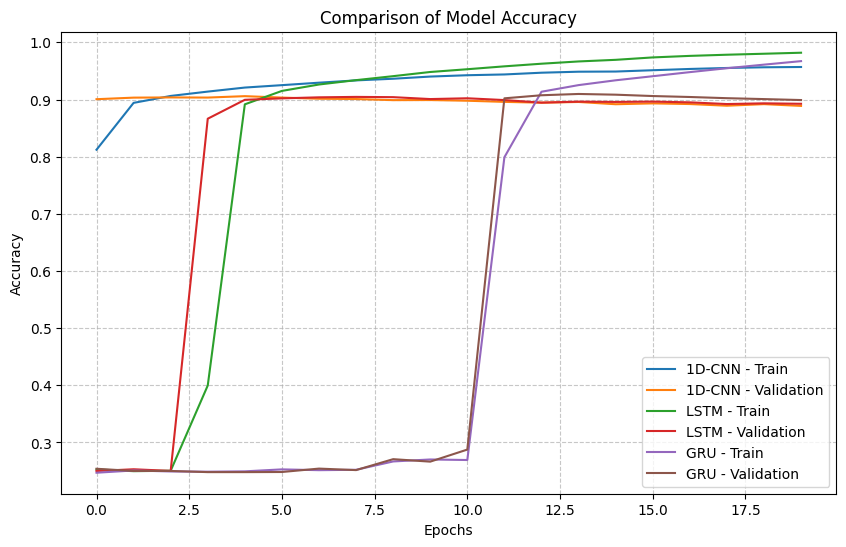

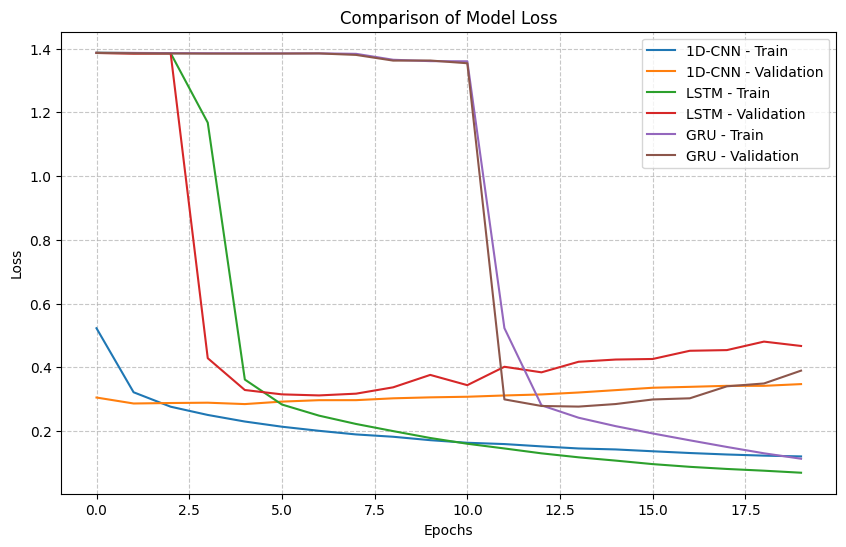

In [10]:
import matplotlib.pyplot as plt

def plot_model_metrics(results, metric, title):
    plt.figure(figsize=(10, 6))
    for model_type, data in results.items():
        history = data["history"]
        plt.plot(history.history[metric], label=f"{model_type} - Train")
        plt.plot(history.history[f"val_{metric}"], label=f"{model_type} - Validation")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(metric.capitalize())
    plt.legend(loc="best")
    plt.grid(visible=True, linestyle="--", alpha=0.7)
    plt.show()

# Визуализация метрик
plot_model_metrics(results, "accuracy", "Comparison of Model Accuracy")
plot_model_metrics(results, "loss", "Comparison of Model Loss")
